In [1]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from models.motion_stn import motion_stn,motion_net
from dataset.dataset_generalize import image_normalizations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images,show_tensor_list

In [2]:
config={}
config['dataset']='FBMS'
config['net_name']='motion_net'
config['train_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Trainingset'
config['val_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Testset'
config['frame_gap']=5
config['log_dir']=os.path.expanduser('~/tmp/logs')
config['epoch']=30
config['init_lr']=1e-4
config['stn_loss_weight']=1.0
config['motion_loss_weight']=1.0
config['pose_mask_reg']=1.0
config['stn_object']='images'
config['note']='wo_stn'
config['save_model']=True

normer=image_normalizations(ways='-1,1')
dataset_loaders={}
for split in ['train','val']:
    xxx_dataset=fbms_dataset(config,split,normalizations=normer)
    xxx_loader=td.DataLoader(dataset=xxx_dataset,batch_size=4,shuffle=True,drop_last=False,num_workers=2)
    dataset_loaders[split]=xxx_loader

model=globals()[config['net_name']]()
# support for cpu/gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

log_dir = os.path.join(config['log_dir'], config['net_name'],
                       config['dataset'], config['note'])
checkpoint_path = get_ckpt_path(log_dir)
model=load_ckpt(model,checkpoint_path)


no checkpoint file given, auto find /home/yzbx/tmp/logs/motion_net/FBMS/wo_stn/2019-01-16___20-25-25/model-last-30.pkl


0 -0.11126059 0.47551855 1.0 -1.0


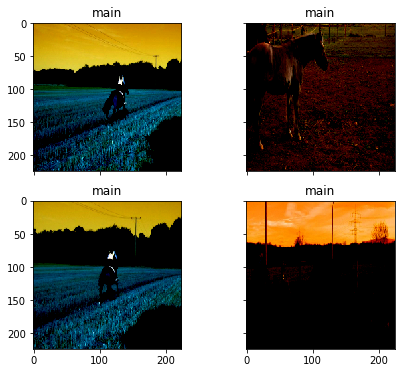

1 -0.10065172 0.4736361 1.0 -1.0


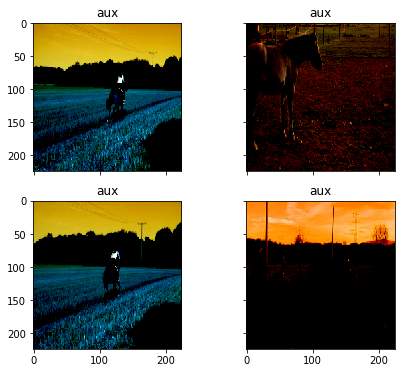

0 0.09004803093112244 0.28625055992355736 1 0


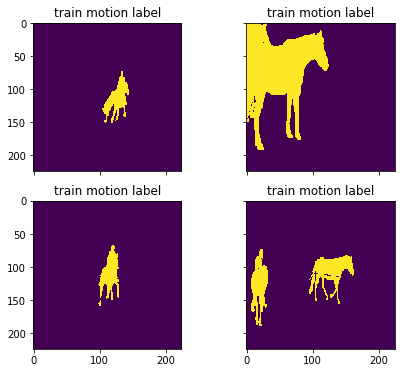

0 0.074617855 0.2037122 0.9561827 7.6587686e-10


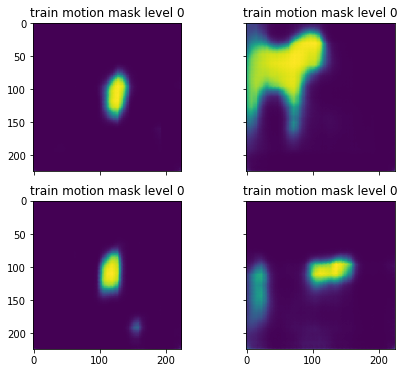

1 0.20687158 0.1298534 0.59821135 0.00020963307


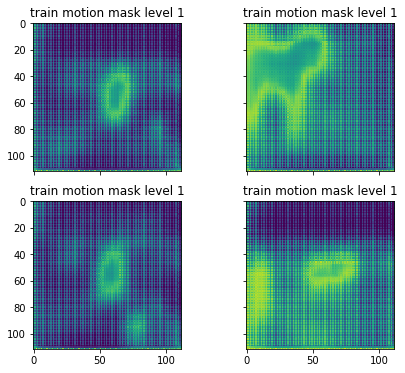

2 0.41449574 0.17407496 0.8596713 0.008997985


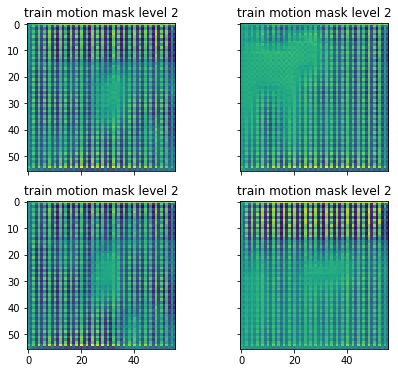

3 0.46694925 0.07794057 0.6366584 0.20159724


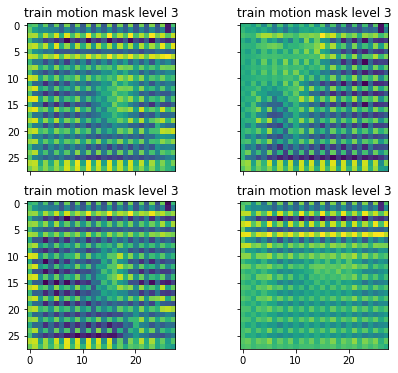

0 -0.13774943 0.46215254 1.0 -1.0


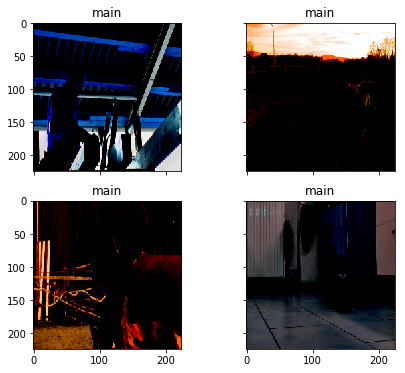

1 -0.11679693 0.4660587 1.0 -1.0


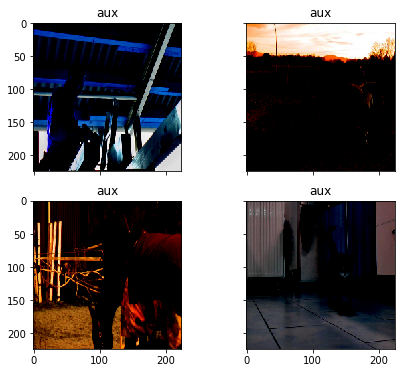

0 0.17338966836734693 0.378583796894173 1 0


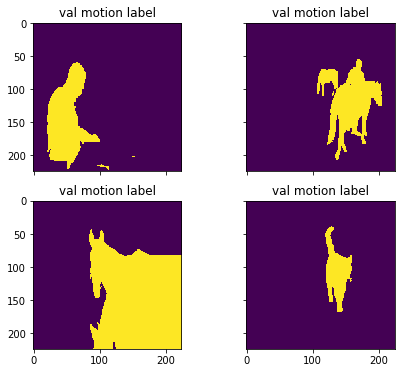

0 0.19228427 0.2960686 0.98286384 1.7161297e-11


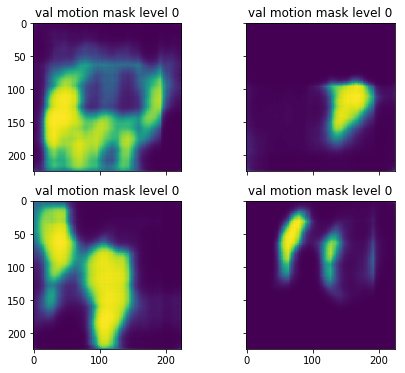

1 0.28043795 0.13253091 0.6141004 4.22801e-05


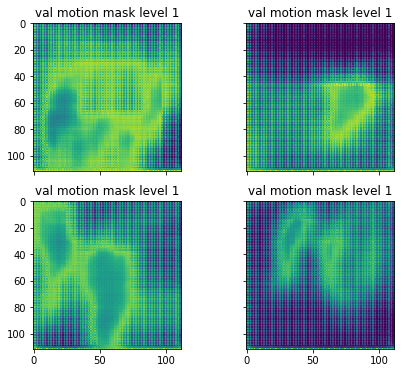

2 0.4450349 0.14139687 0.85531604 0.0038569532


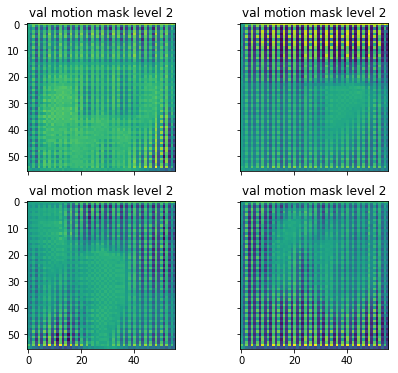

3 0.48175263 0.06570539 0.70930636 0.16403586


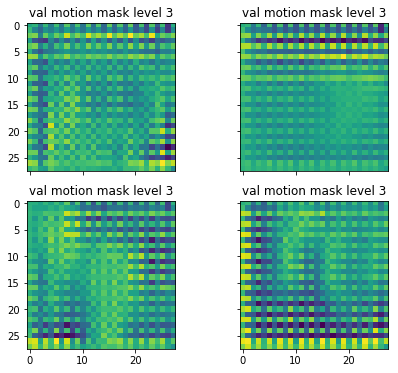

In [3]:
model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
        
        show_tensor_list(images,['main','aux'])
        show_tensor_list([gt],[split+' motion label'])
        show_tensor_list(outputs['masks'],[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        break